# Weather Prediction using Neural Network

Personal project as part of my portfolio.

# Table of Contents

1. [Introduction](#introduction)
2. [Packages](#packages)
3. [Load the data](#load-data)
4. [Preprocess the data](#preprocess-data)
5. [Build the model](#model)
5. [Pipeline](#pipeline)



# Introduction <a class="anchor" id="introduction"></a>

# 1 - Packages <a class="anchor" id="packages"></a>

In [40]:
import tensorflow as tf
import numpy as np
import tensorflow.keras.layers as tfl
import pandas as pd

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.utils import get_file 
from tensorflow.keras.utils import load_img 
from tensorflow.keras.utils import img_to_array
import matplotlib.pyplot as plt

import tensorflow.keras.layers as tfl

import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

## 2 - Load the data <a class="anchor" id="load-data"></a>

### Steps:
- Make a list of all the images in the directory (path images)
- Split path to get the name of the folder (label) and store it in a list (labels)
- With labels and images, create a dataframe (data)

In [5]:
def load_img_data_to_df(path, img_extension='.jpg'):
    """
    Loads images from a directory and returns a dataframe with the image path and the label.
    """
    img_paths = (glob.glob(path+'/**/*'))
    labels = [x.split(os.sep)[-2] for x in img_paths]
    file_path = pd.Series(img_paths)
    labels = pd.Series(labels)
    df = pd.DataFrame({'File_Path': file_path, 'Labels': labels})
    # Shuffle the dataframe
    df = df.sample(frac=1).reset_index(drop=True)
    return df

In [6]:
path = 'dataset/'
data = load_img_data_to_df(path)
data.head()

,File_Path,Labels
0,dataset\frost\3884.jpg,frost
1,dataset\lightning\1903.jpg,lightning
2,dataset\fogsmog\4849.jpg,fogsmog
3,dataset\snow\1171.jpg,snow
4,dataset\rime\5480.jpg,rime


# 2 - EDA - Exploratory Data Analysis <a class="anchor" id="eda"></a>

### Steps:

- Check the dataframe (data)
- Check the distribution of the data
- Plot some images from the data

In [7]:
def plot_image_and_labels(data: pd.DataFrame, n_rows: int=4, n_cols: int=4, figsize: tuple=(10,10)):
    """
    Show images and labels in a grid of n_rows x n_cols. Dataframe must have the columns 'File_Path' and 'Labels'.
    Args:
        data: Dataframe with the columns 'File_Path' and 'Labels'
        n_rows (opt): Number of rows in the grid
        n_cols (opt): Number of columns in the grid
        figsize (opt): Figure size
    """
    fig, ax = plt.subplots(n_rows, n_cols, figsize=figsize)
    for i, ax in enumerate(ax.flat):
        img = plt.imread(data['File_Path'][i])
        ax.imshow(img)
        ax.set(title=data['Labels'][i])
        ax.axis('off')

In [8]:
def plot_label_distribution(data: pd.DataFrame):
    """
    View the distribution of labels in the dataframe.
    """
    sns.set_theme(style="darkgrid")
    sns.countplot(x='Labels',data=data, alpha=0.8, order=data['Labels'].value_counts().index)
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.xticks(rotation=50)
    plt.show()

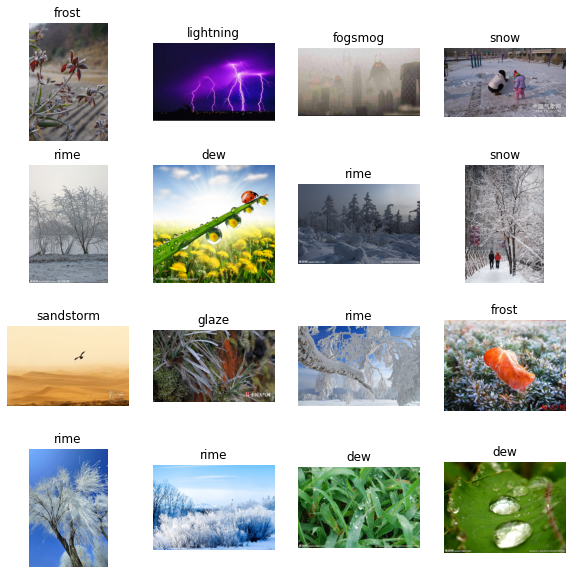

In [9]:
plot_image_and_labels(data)

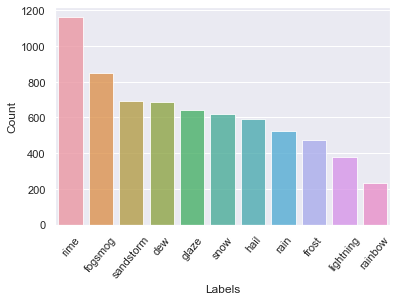

In [10]:
plot_label_distribution(data)

The data is imbalanced, so it would be great to use some methods to balance the data. Not in the scope of this project.

# 3 - Preprocess Data <a class="anchor" id="preprocess-data"></a>

We use the ImageDataGenerator to generate batches of images and apply transformations to them before feeding them to the neural network. Image augmentation is a technique that is used to increase the number of training examples, as the dataset is too small to train the network on.

In [11]:
def image_generator_from_df(data, preprocessing_function=None, batch_size=32, image_size=(224,224), seed=42):
    """
    Generates batches of tensor image data with real-time data augmentation from dataframe.
    Args:
        data: Dataframe with the columns 'File_Path' and 'Labels'
        preprocessing_function (opt): Function to preprocess the image data. Important to use the same preprocessing function if you want to use transfer learning.
        batch_size (opt): Batch size. Default is 32.
        image_size (opt): Image size. Default is (224,224).
        seed (opt): Random seed. Default is 42. Needed to make sure that the same data is used for training and validation.
    """
    train_datagen = ImageDataGenerator(validation_split=0.2, preprocessing_function=preprocessing_function)
    train_gen = train_datagen.flow_from_dataframe(
        dataframe = data,
        x_col = 'File_Path',
        y_col = 'Labels',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        subset='training',
        seed=seed,
        horizontal_flip=True,
        zoom_range=0.2,
        rotation_range=20,
        )
    valid_gen = train_datagen.flow_from_dataframe(
        dataframe = data,
        x_col = 'File_Path',
        y_col = 'Labels',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        subset='validation',
        seed=seed,
        horizontal_flip=True,
        zoom_range=0.2,
        rotation_range=20,
        )
    return train_gen, valid_gen

# 4 - Build the Model <a class="anchor" id="model"></a>

As we are implementing a CNN for image recognition and the training dataset is small, it could be useful to retrain a model from the Keras library as a starting point. The model will already be trained on the low-level features of the images, so we can replace last layers to classify on our custom labels.

In [12]:
from tensorflow.keras.applications import EfficientNetB7, InceptionV3, MobileNetV2, ResNet50, VGG19, Xception
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_input_efficientnet
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_input_mobilenet
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_input_inception
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_resnet
from tensorflow.keras.applications.vgg19 import preprocess_input as preprocess_input_vgg
from tensorflow.keras.applications.xception import preprocess_input as preprocess_input_xception

In [13]:
def get_pretrained_model(model, input_shape, n_classes, dropout_rate: int | None=None, preprocessing_function=None):
    """
    Adapts and add last layers to a pretrained image classification model. 
    Args:
        model: Pretrained model to use from get_base_model()
        input_shape: Input shape of the model.
        dropout_rate (opt): Dropout rate. If None, no dropout is used.
        n_classes: Number of classes for output layer
    """
    inputs = tf.keras.Input(shape=input_shape)
    # Apply preprocessing function to input
    if preprocessing_function is not None:
        inputs = preprocessing_function(inputs)
    x = model(inputs, training=False)
    # Use global average pooling to get the final feature vector
    x = tfl.GlobalAveragePooling2D()(x)
    # Add a dense layer with relu activation
    x = tfl.Dense(64, activation='relu')(x)
    # If dropout rate is not None, add dropout layer
    if dropout_rate is not None:
        x = tfl.Dropout(dropout_rate)(x)
    # Add a fully connected layer with n_classes neurons
    outputs = Dense(n_classes, activation='softmax')(x)
    # Create model
    model = Model(inputs, outputs)
    # Compile model
    optimizer = tf.keras.optimizers.Adam()
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

In [14]:
def get_base_model(model_name, input_shape):
    """
    Returns model based on the model_name and preprocessing function.
    Args:
        model_name: Name of the model.
        input_shape: Shape of the input.
    """
    if model_name == 'EfficientNetB7':
        model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape)
        preprocessing_function = preprocess_input_efficientnet
    elif model_name == 'InceptionV3':
        model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
        preprocessing_function = preprocess_input_inception
    elif model_name == 'MobileNetV2':
        model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
        preprocessing_function = preprocess_input_mobilenet
    elif model_name == 'ResNet50':
        model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
        preprocessing_function = preprocess_input_resnet
    elif model_name == 'VGG19':
        model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
        preprocessing_function = preprocess_input_vgg
    elif model_name == 'Xception':
        model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
        preprocessing_function = preprocess_input_xception
    else:
        raise ValueError('Model name not recognized.')
    model.trainable = False
    return model, preprocessing_function

In [15]:
def plot_history(history):
    """
    Plots the history of the training and validation accuracy and loss.
    Args:
        history: History object returned by model.fit()
    """
    plt.figure(figsize=(10,10))
    plt.subplot(2,1,1)
    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(2,1,2)
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# 5 - Pipeline <a class="anchor" id="pipeline"></a>

In [16]:
path = 'dataset/'
BATCH_SIZE = 32
IMAGE_SIZE = (128,128)
EPOCHS = 10
models = ['EfficientNetB7', 'MobileNetV2', 'ResNet50', 'VGG19', 'Xception']
# 1. Load data
data = load_img_data_to_df(path)
# 2. Split data into train and test and apply preprocessing
train, test = image_generator_from_df(data, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE)

Found 5480 validated image filenames belonging to 11 classes.
Found 1369 validated image filenames belonging to 11 classes.


In [17]:
# ----------------------------------------------------------------------------------------------------------------------
# 3. Train and evaluate models
models_dict = {}
for model_name in models:
    model_path = 'models/' + model_name + '.h5'
    # 3.1. Get base model
    model, pre_function = get_base_model(model_name, input_shape=IMAGE_SIZE + (3,))
    # 3.2. Adapt pretrained model
    model = get_pretrained_model(model, preprocessing_function=pre_function, input_shape=IMAGE_SIZE + (3,), n_classes=len(data['Labels'].unique()), dropout_rate=0.2)
    # 3.3. Train model
    my_callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')]
    history = model.fit(train, epochs=EPOCHS, validation_data=test, callbacks=my_callbacks)
    # 3.4. Evaluate model
    results = model.evaluate(test)
    # Plot history
    plot_history(history)
    # 3.4. Save model
    model.save(model_path)
    # 3.5 Store model and history in a dictionary
    models_dict[model_name] = {'model': model, 'history': history, 'results': results}

Epoch 1/10
172/172 [==============================] - 55s 177ms/step - loss: 1.0845 - accuracy: 0.6516 - val_loss: 0.6807 - val_accuracy: 0.7779
Epoch 2/10
172/172 [==============================] - 20s 118ms/step - loss: 0.6750 - accuracy: 0.7801 - val_loss: 0.6337 - val_accuracy: 0.7882
Epoch 3/10
172/172 [==============================] - 21s 120ms/step - loss: 0.5551 - accuracy: 0.8204 - val_loss: 0.5969 - val_accuracy: 0.7969
Epoch 4/10
172/172 [==============================] - 21s 120ms/step - loss: 0.4803 - accuracy: 0.8392 - val_loss: 0.5619 - val_accuracy: 0.8093
Epoch 5/10
172/172 [==============================] - 21s 119ms/step - loss: 0.4266 - accuracy: 0.8589 - val_loss: 0.5858 - val_accuracy: 0.7955
Epoch 6/10
172/172 [==============================] - 21s 121ms/step - loss: 0.3856 - accuracy: 0.8723 - val_loss: 0.5375 - val_accuracy: 0.8159
Epoch 7/10
172/172 [==============================] - 21s 119ms/step - loss: 0.3382 - accuracy: 0.8896 - val_loss: 0.5546 - val_ac

# Reports <a class="anchor" id="reports"></a>

In [ ]:
import pickle

def save_results(models_dict):
    history_dict = {}
    for model_name in models:
        history_dict[model_name] = models_dict[model_name]['history']
        print(model_name + ': ' + str(models_dict[model_name]['results']))
    with open('models/modelsHistoryDict', 'wb') as file_pi:
        pickle.dump(history_dict, file_pi)

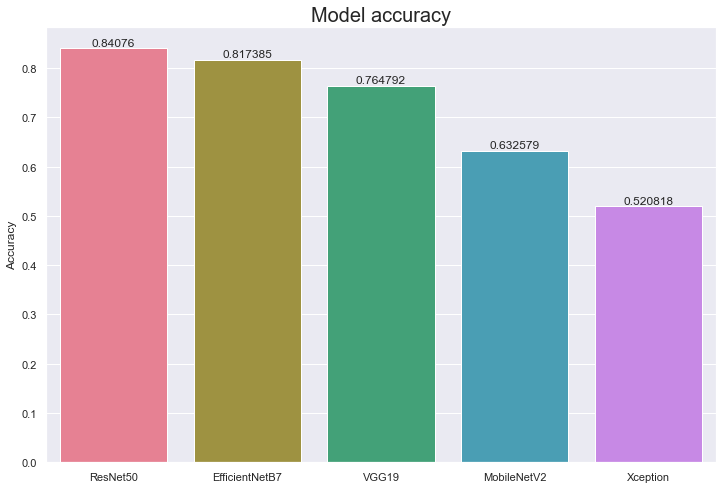

In [39]:
def display_results(models_dict):
    results_df = pd.DataFrame.from_dict(models_dict, orient='index')
    results_df['Accuracy'] = results_df['results'].apply(lambda x: x[1])
    results_df['Loss'] = results_df['results'].apply(lambda x: x[0])
    results_df = results_df.drop('results', axis=1)
    results_df = results_df.sort_values(by='Accuracy', ascending=False)
    # Set figure size
    plt.figure(figsize=(12,8))
    plt.title('Model accuracy', fontsize=20)
    ax = sns.barplot(y='Accuracy', x=results_df.index, data=results_df, palette='husl', orient='v')
    ax.bar_label(ax.containers[0], fontsize=12)
display_results(models_dict)

43/43 [==============================] - 5s 119ms/step
              precision    recall  f1-score   support

         dew       0.88      0.96      0.91       135
     fogsmog       0.91      0.87      0.89       178
       frost       0.69      0.69      0.69        95
       glaze       0.79      0.63      0.70       150
        hail       0.88      0.93      0.91       104
   lightning       0.96      0.96      0.96        69
        rain       0.81      0.86      0.84       110
     rainbow       0.93      0.97      0.95        39
        rime       0.82      0.86      0.84       238
   sandstorm       0.91      0.90      0.90       138
        snow       0.72      0.73      0.73       113

    accuracy                           0.84      1369
   macro avg       0.85      0.85      0.85      1369
weighted avg       0.84      0.84      0.84      1369



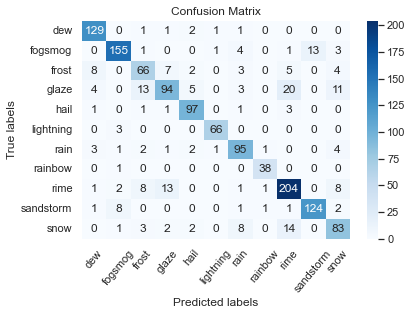

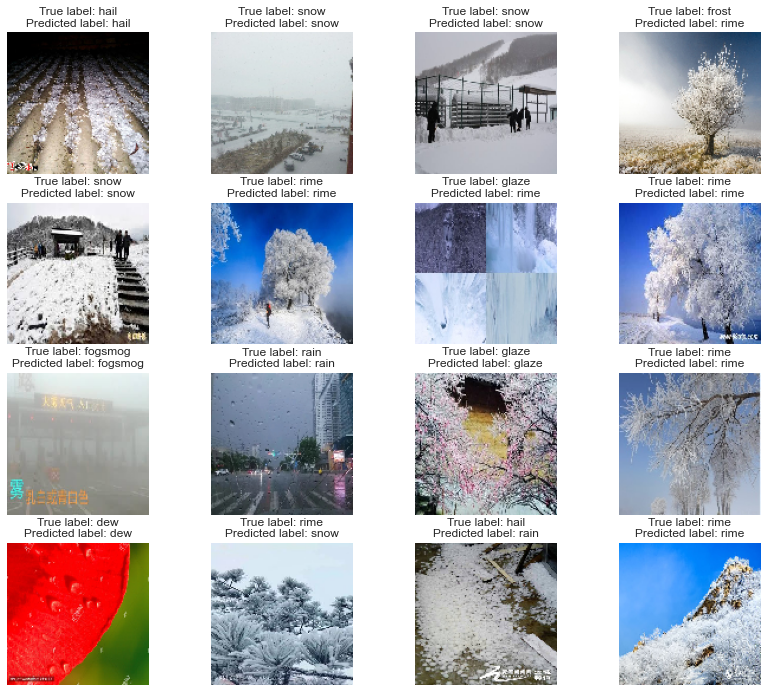

In [35]:
def plot_classification_report(model, test_data):
    """
    Plots classification report from sklearn and a few predictions from test data
    """
    pred = model.predict(test_data)
    pred = np.argmax(pred, axis=1)
    # Get test data labels
    labels = test_data.class_indices
    labels = {v: k for k, v in labels.items()}
    pred = [labels[k] for k in pred]
    test_labels = [labels[k] for k in test_data.labels]
    clr = classification_report(test_labels, pred)
    print(clr)
    cf = confusion_matrix(test_labels, pred)
    # Confusion matrix
    ax= plt.subplot()
    sns.heatmap(cf, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(labels.values(), rotation=50)
    ax.yaxis.set_ticklabels(labels.values(), rotation=0)
    # Display x pictures with their predictions
    fig, ax = plt.subplots(4, 4, figsize=(14,12))
    for i, ax in enumerate(ax.flat):
        ax.imshow(test_data[0][0][i].astype(np.uint8))
        ax.set_title(f'True label: {test_labels[i]}\nPredicted label: {pred[i]}')
        ax.axis('off')
plot_classification_report(models_dict[best_model]['model'], test)

# Test prediction

In [51]:
from numpy import expand_dims

image = load_img('dataset/rime/4950.jpg', target_size=(120, 120))
image = expand_dims(image, axis=0)
pred = models_dict[best_model]['model'].predict(image)
pred = np.argmax(pred, axis=1)
# Get test data labels
labels = train.class_indices
labels = {v: k for k, v in labels.items()}
pred = [labels[k] for k in pred]
pred

1/1 [==============================] - 1s 1s/step


['rime']

In [59]:
img_link = 'https://cloudfront-us-east-1.images.arcpublishing.com/gray/LW2N62X6Z5F7BM3EKFQXWAC46E.jpg'
img_path = get_file(origin=img_link)
image = load_img(img_path, target_size=(120, 120))
image = expand_dims(image, axis=0)
score = models_dict[best_model]['model'].predict(image)
model_score = round(score.max()*100, 2)
pred = np.argmax(score, axis=1)
# Get test data labels
labels = train.class_indices
labels = {v: k for k, v in labels.items()}
pred = [labels[k] for k in pred]

# Generate json from list of predictions
mydict =  {"label": pred,
            'confidence_score': model_score}
mydict

1/1 [==============================] - 0s 27ms/step


{'label': ['snow'], 'confidence_score': 49.23}